In [57]:
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [8]:
def imread(path):
    return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

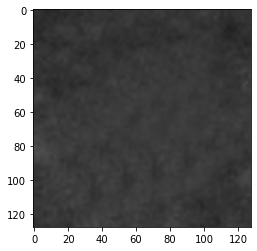

In [9]:
bgframe = imread('train_bgframe.png')
plt.imshow(bgframe)
plt.show()

In [6]:
paths = glob.glob('images/train/*/*.png')
len(paths)

18000

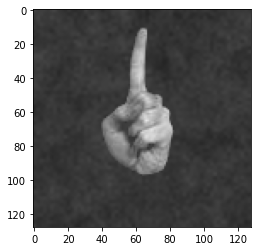

In [12]:
fgframe = imread(paths[0])
plt.imshow(fgframe)
plt.show()

In [60]:
fgframe.shape

(128, 128, 3)

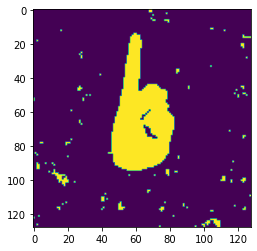

In [50]:
fgframe = imread(paths[1])
history = 10
bgsub = cv2.createBackgroundSubtractorMOG2(history=history, detectShadows=False)
plt.imshow(bgsub.apply(imread('train_bgframe1.png')))
plt.imshow(bgsub.apply(imread('train_bgframe2.png')))
plt.imshow(bgsub.apply(imread('train_bgframe3.png')))
plt.imshow(bgsub.apply(imread('train_bgframe4.png')))
plt.imshow(bgsub.apply(imread('train_bgframe5.png')))
plt.imshow(bgsub.apply(fgframe))

In [151]:
def preprocess_frame(frame):
    bgsub = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
    bgsub.apply(imread('train_bgframe1.png'))
    bgsub.apply(imread('train_bgframe2.png'))
    bgsub.apply(imread('train_bgframe3.png'))
    bgsub.apply(imread('train_bgframe4.png'))
    bgsub.apply(imread('train_bgframe5.png'))
    mask = bgsub.apply(frame)
#     return mask
    return np.expand_dims(mask, axis=2)
#     return cv2.bitwise_and(frame, frame, mask=mask)

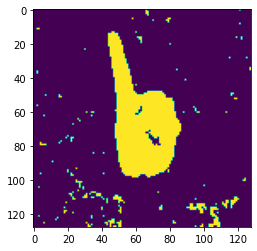

(128, 128, 1)

In [152]:
frame = preprocess_frame(imread(paths[5]))
plt.imshow(frame)
plt.show()
frame.shape

In [177]:
sample = random.sample(paths, 1000)
X = np.array([preprocess_frame(imread(path)) for path in sample])
Y = np.array([int(path.split('_')[1][:1]) for path in sample])
X.shape, Y.shape

((1000, 128, 128, 1), (1000,))

In [178]:
from collections import Counter
Counter(Y)

Counter({4: 153, 0: 181, 2: 161, 5: 159, 1: 169, 3: 177})

In [181]:
np.savez('bgdata', X=X, Y=Y)

In [184]:
npzfile = np.load('bgdata.npz')
X, Y = npzfile['X'], npzfile['Y']
X.shape, Y.shape

((1000, 128, 128, 1), (1000,))

In [192]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y)
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((750, 128, 128, 1), (750,), (250, 128, 128, 1), (250,))

In [232]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, input_shape=(128, 128, 1)),
    keras.layers.AveragePooling2D(3),
    keras.layers.Conv2D(64, 3),
    keras.layers.MaxPooling2D(3),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(6, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
average_pooling2d_2 (Average (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 10816)             0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 10816)             43264     
_________________________________________________________________
dense_46 (Dense)             (None, 32)              

In [233]:
history = model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs=7)

Train on 750 samples, validate on 250 samples
Epoch 1/7
750/750 [==============================] - 13s 17ms/sample - loss: 0.6671 - accuracy: 0.7587 - val_loss: 1.7300 - val_accuracy: 0.6960
Epoch 2/7
750/750 [==============================] - 11s 15ms/sample - loss: 0.0944 - accuracy: 0.9720 - val_loss: 1.1736 - val_accuracy: 0.7640
Epoch 3/7
750/750 [==============================] - 10s 13ms/sample - loss: 0.0177 - accuracy: 0.9973 - val_loss: 0.3524 - val_accuracy: 0.8960
Epoch 4/7
750/750 [==============================] - 10s 13ms/sample - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.2635 - val_accuracy: 0.9200
Epoch 5/7
750/750 [==============================] - 10s 13ms/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1527 - val_accuracy: 0.9480
Epoch 6/7
750/750 [==============================] - 10s 13ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.1207 - val_accuracy: 0.9640
Epoch 7/7
750/750 [==============================] - 10s 13ms/sample - loss: 0.0025 

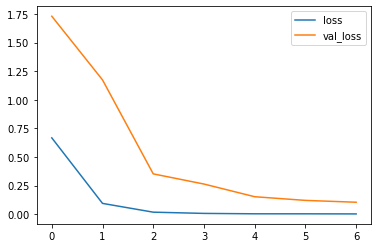

In [234]:
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot()
plt.show()

In [235]:
model.save('bgmodel')

INFO:tensorflow:Assets written to: bgmodel/assets
